In [1]:
'''
Objective:
SVD for image compression example
Author:
Goran Trlin
Prerequisites:
pip install numpy
pip install pillow
Video tutorial URL:
https://www.youtube.com/watch?v=SU851ljMIZ8
'''

import numpy
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

from random import normalvariate
from math import sqrt

In [ ]:
def svd_simultaneous_power_iteration(A, k, epsilon=0.00001):
    #source http://mlwiki.org/index.php/Power_Iteration
    #adjusted to work with n<m and n>m matrices
    n_orig, m_orig = A.shape
    if k is None:
        k=min(n_orig,m_orig)
    A_orig=A.copy()
    if n_orig > m_orig:
        A = A.T @ A
        n, m = A.shape
    elif n_orig < m_orig:
        A = A @ A.T
        n, m = A.shape
    else:
        n,m=n_orig, m_orig
        
    Q = np.random.rand(n, k)
    Q, _ = np.linalg.qr(Q)
    Q_prev = Q
    #this part does the block power iteration
    for i in range(1000):
        Z = A @ Q
        Q, R = np.linalg.qr(Z)
        err = ((Q - Q_prev) ** 2).sum()
        Q_prev = Q
        if err < epsilon:
            break
            
    singular_values=np.sqrt(np.diag(R)) 
    #deal with different shape input matrices
    if n_orig < m_orig: 
        left_vecs=Q.T
        #use property Values @ V = U.T@A => V=inv(Values)@U.T@A
        right_vecs=np.linalg.inv(np.diag(singular_values))@left_vecs.T@A_orig
    elif n_orig==m_orig:
        left_vecs=Q.T
        right_vecs=left_vecs
        singular_values=np.square(singular_values)
    else:
        right_vecs=Q.T
        #use property Values @ V = U.T@A => U=A@V@inv(Values)
        left_vecs=A_orig@ right_vecs.T @np.linalg.inv(np.diag(singular_values))

    return singular_values, left_vecs, right_vecs

In [2]:
# FUNCTION DEFINTIONS:

# open the image and return 3 matrices, each corresponding to one channel (R, G and B channels)
def openImage(imagePath):
    imOrig = Image.open(imagePath)
    im = numpy.array(imOrig)

    aRed = im[:, :, 0]
    aGreen = im[:, :, 1]
    aBlue = im[:, :, 2]

    return [aRed, aGreen, aBlue, imOrig]

def randomUnitVector(n):
    unnormalized = [normalvariate(0, 1) for _ in range(n)]
    theNorm = sqrt(sum(x * x for x in unnormalized))
    return [x / theNorm for x in unnormalized]


def svd_1d(A, epsilon=1e-10):
    ''' The one-dimensional SVD '''

    n, m = A.shape
    x = randomUnitVector(min(n,m))
    lastV = None
    currentV = x

    if n > m:
        B = np.dot(A.T, A)
    else:
        B = np.dot(A, A.T)

    iterations = 0
    while True:
        iterations += 1
        lastV = currentV
        currentV = np.dot(B, lastV)
        currentV = currentV / norm(currentV)

        if abs(np.dot(currentV, lastV)) > 1 - epsilon:
#             print("converged in {} iterations!".format(iterations))
            return currentV


def svd(A, k=None, epsilon=1e-10):
    '''
        Compute the singular value decomposition of a matrix A
        using the power method. A is the input matrix, and k
        is the number of singular values you wish to compute.
        If k is None, this computes the full-rank decomposition.
    '''
    A = np.array(A, dtype=float)
    n, m = A.shape
    svdSoFar = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrixFor1D = A.copy()

        for singularValue, u, v in svdSoFar[:i]:
            matrixFor1D -= singularValue * np.outer(u, v)

        if n > m:
            v = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            u_unnormalized = np.dot(A, v)
            sigma = norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            u = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            v_unnormalized = np.dot(A.T, u)
            sigma = norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svdSoFar.append((sigma, u, v))

    singularValues, us, vs = [np.array(x) for x in zip(*svdSoFar)]
    return singularValues, us.T, vs



# compress the matrix of a single channel
def compressSingleChannel(channelDataMatrix, singularValuesLimit):
    k = singularValuesLimit
    sChannel, uChannel, vhChannel = svd(channelDataMatrix, k)
    sChannel = np.diag(sChannel)
#     aChannelCompressed = numpy.zeros((channelDataMatrix.shape[0], channelDataMatrix.shape[1]))
    
    aChannelCompressed = uChannel[:, :k] @ sChannel[0:k, :k] @ vhChannel[:k, :]
#     leftSide = numpy.matmul(uChannel[:, 0:k], numpy.diag(sChannel)[0:k, 0:k])
#     aChannelCompressedInner = numpy.matmul(leftSide, vhChannel[0:k, :])
#     aChannelCompressed = aChannelCompressedInner.astype('uint8')
    return aChannelCompressed

In [3]:
# aRed, aGreen, aBlue, originalImage = openImage('lena.png')
# singularValuesLimit = 20
# aRedCompressed = compressSingleChannel(aRed[:20, ], singularValuesLimit)

In [34]:
# for r in (5, 20, 100, 512):
# MAIN PROGRAM:
def main(file):
    print('*** Image Compression using SVD - a demo')
    aRed, aGreen, aBlue, originalImage = openImage(file)

    # image width and height:
    imageWidth = 300
    imageHeight = 500

    # number of singular values to use for reconstructing the compressed image
    singularValuesLimit = 150

    aRedCompressed = compressSingleChannel(aRed, singularValuesLimit)
    aGreenCompressed = compressSingleChannel(aGreen, singularValuesLimit)
    aBlueCompressed = compressSingleChannel(aBlue, singularValuesLimit)

    imr = (Image.fromarray(aRedCompressed, mode=None)).convert('L')
    img = (Image.fromarray(aGreenCompressed, mode=None)).convert('L')
    imb = (Image.fromarray(aBlueCompressed, mode=None)).convert('L')

    newImage = Image.merge("RGB", (imr, img, imb))

    plt.rcParams['figure.figsize'] = [16,8]
    new = plt.imshow(newImage)
    plt.axis('off')
    plt.show()

    # CALCULATE AND DISPLAY THE COMPRESSION RATIO
    mr = imageHeight
    mc = imageWidth

    originalSize = mr * mc * 3
    compressedSize = singularValuesLimit * (1 + mr + mc) * 3

    print('original size:')
    print(originalSize)

    print('compressed size:')
    print(compressedSize)

    print('Ratio compressed size / original size:')
    ratio = compressedSize * 1.0 / originalSize
    print(ratio)

    print('Compressed image size is ' + str(round(ratio * 100, 2)) + '% of the original image ')
    print('DONE - Compressed the image! Over and out!')

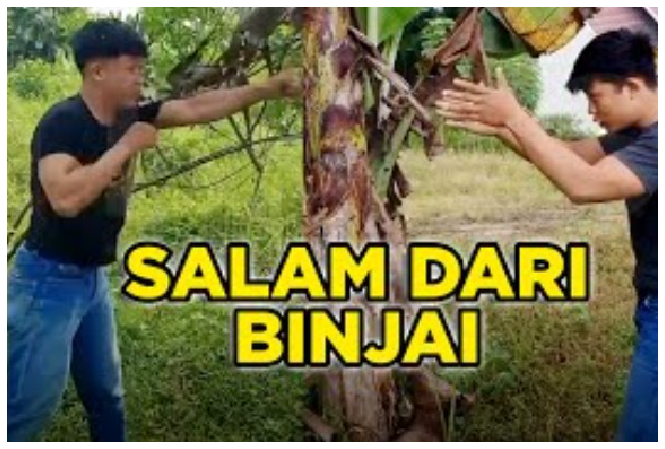

In [35]:
plt.rcParams['figure.figsize'] = [16,8]
ori = plt.imread('binjai.jpeg')
ori = ori
plt.imshow(ori)
plt.axis('off')
plt.show()

*** Image Compression using SVD - a demo


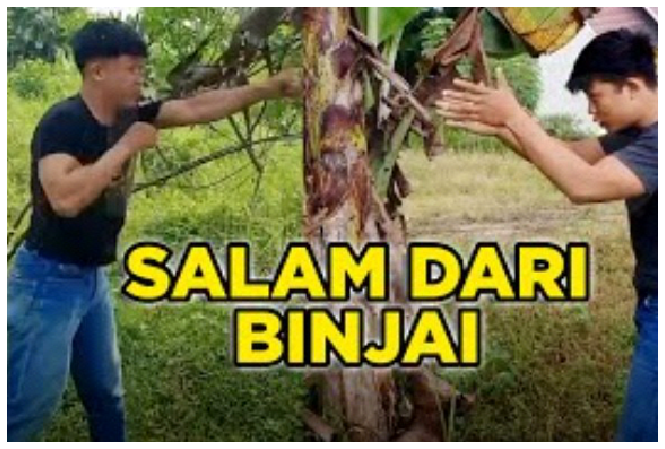

original size:
450000
compressed size:
360450
Ratio compressed size / original size:
0.801
Compressed image size is 80.1% of the original image 
DONE - Compressed the image! Over and out!
--- 127.01675057411194 seconds ---


In [36]:
import time
start_time = time.time()
main('binjai.jpeg')
print("--- %s seconds ---" % (time.time() - start_time))